## This notebook run the Key-Point Moseq model on your data and computes syllables for all videos and saves the results in a csv file. It also saves movie snippets for each syllable. 

#### 
    - Setting environment variables to allow JAX to free GPU memory when not needed and also restrict it to not pre-allocate all the GPU memory. This allows us to have more GPU space at the cost of slightly slower computation time.:w


In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax
print(jax.devices()[0].platform)

cpu


### Imports

In [5]:
import sys, os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import pathlib
import logging

In [6]:
from src.utils import set_up_logging, print_gpu_usage
from src.methods import load_and_format_data, perform_pca, fit_and_save_model, generate_plots_and_movies
from src.preprocessing import h5_to_csv_poses

In [7]:
from jax_moseq.utils import set_mixed_map_iters
import keypoint_moseq as kpms

In [9]:
import jax
print(jax.devices()[0].platform)


cpu


## GLOBALS

In [10]:
G_MIXED_MAP_ITERS = 8
G_ARHMM_ITERS = 20 # Number of ARHMM steps 
G_FULL_MODEL_ITERS = 20 # Number of full model steps
G_KAPPA = 1e7 # Stickiness parameter to control the timescale of behaviors (higher value leads to longer bouts)


In [11]:
# Set this parameter such that the model fits into the GPU (slows the computation by the same factor)
set_mixed_map_iters(G_MIXED_MAP_ITERS)

<div class="alert alert-block alert-info">
ⓘ As an example, I'm using examples folder but the data should ideally sit at data folder in this repository.
</div>

In [12]:
G_BASE_PATH = "/Users/chouda/JaX/KumarLab/unsupervised_behavior_jax/"
G_PROJ_NAME = "test"
G_PROJ_PATH = G_BASE_PATH + "results/" + G_PROJ_NAME + "/"  
G_VIDEO_DIR = G_BASE_PATH + "examples/jabs600_v2/videos/" 
G_POSE_DIR = G_BASE_PATH + "examples/jabs600_v2/poses/" 

In [13]:
# Setting body parts and skeleton for 12 keypoints, change accordingly if you have different number of keypoints
G_BODYPARTS = [
    "NOSE_INDEX",
    "LEFT_EAR_INDEX",
    "RIGHT_EAR_INDEX",
    "BASE_NECK_INDEX",
    "LEFT_FRONT_PAW_INDEX",
    "RIGHT_FRONT_PAW_INDEX",
    "CENTER_SPINE_INDEX",
    "LEFT_REAR_PAW_INDEX",
    "RIGHT_REAR_PAW_INDEX",
    "BASE_TAIL_INDEX",
    "MID_TAIL_INDEX",
    "TIP_TAIL_INDEX",
]

G_SKELETON = [
    ["TIP_TAIL_INDEX", "MID_TAIL_INDEX"],
    ["MID_TAIL_INDEX", "BASE_TAIL_INDEX"],
    ["BASE_TAIL_INDEX", "RIGHT_REAR_PAW_INDEX"],
    ["BASE_TAIL_INDEX", "LEFT_REAR_PAW_INDEX"],
    ["BASE_TAIL_INDEX", "CENTER_SPINE_INDEX"],
    ["CENTER_SPINE_INDEX", "LEFT_FRONT_PAW_INDEX"],
    ["CENTER_SPINE_INDEX", "RIGHT_FRONT_PAW_INDEX"],
    ["CENTER_SPINE_INDEX", "BASE_NECK_INDEX"],
    ["BASE_NECK_INDEX", "NOSE_INDEX"],
]


## Project Setup 

In [14]:

def initialize_project():
    """Initialize project settings and configurations."""

    set_mixed_map_iters(G_MIXED_MAP_ITERS)

    project_path = pathlib.Path(G_PROJ_PATH)

    kpms.setup_project(
        project_path, video_dir=G_VIDEO_DIR, bodyparts=G_BODYPARTS, skeleton=G_SKELETON
    )

    log_dir = pathlib.Path(G_PROJ_PATH) / "logs"
    set_up_logging(log_dir)

    logging.info(f"Set mixed map iters to {G_MIXED_MAP_ITERS}")

    kpms.update_config(
        project_path,
        anterior_bodyparts=["BASE_NECK_INDEX"], # Select as per your problem of interest
        posterior_bodyparts=["BASE_TAIL_INDEX"], # Select as per your problem of interest
        use_bodyparts=G_BODYPARTS,
    )

    return project_path

## Main code 

### Preprocess the pose data into the correct format for the model

<div class="alert alert-block alert-warning">
⚠️ ONLY RUN THE FOLLOWING CELL ONCE TO INITIALIZE THE PROJECT
</div>

In [15]:
# WARNING: ONLY RUN THIS ONCE TO INITIALIZE THE PROJECT
project_path = initialize_project()

G_POSE_CSV_DIR = G_BASE_PATH + "examples/jabs600_v2/poses_csv/"
# if the directory is not empty, skip this step
if os.listdir(G_POSE_CSV_DIR):
    logging.info(f"The directory {G_POSE_CSV_DIR} is not empty. Skipping this step.")
else:
    logging.info(f"The directory {G_POSE_CSV_DIR} is empty. Running h5_to_csv_poses()...")
    h5_to_csv_poses(G_POSE_DIR, G_POSE_CSV_DIR)

### Run the model on the data

100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Done reading all files in /Users/chouda/JaX/KumarLab/unsupervised_behavior_jax/examples/jabs600_v2/poses_csv/
>=90.0% of variance exlained by 4 components.


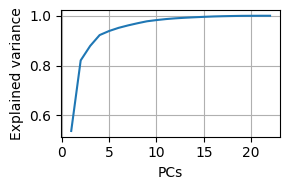

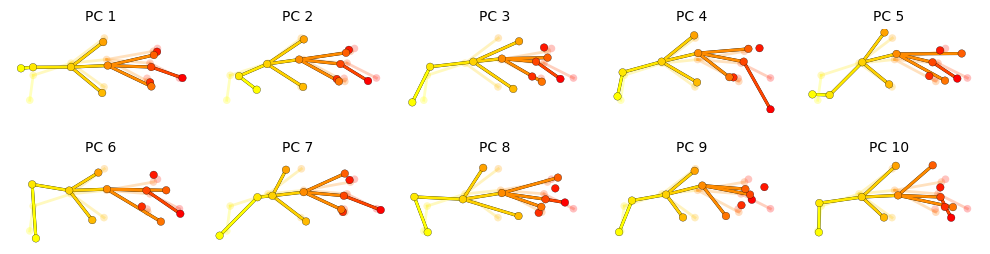

Outputs will be saved to /Users/chouda/JaX/KumarLab/unsupervised_behav
ior_jax/results/test/2025_01_08-14_21_56


 95%|█████████████████████████████████▎ | 20/21 [00:29<00:01,  1.35s/it]

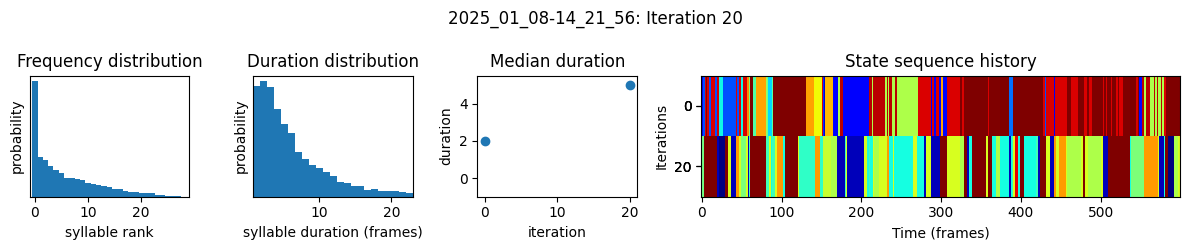

100%|███████████████████████████████████| 21/21 [00:30<00:00,  1.47s/it]


Outputs will be saved to /Users/chouda/JaX/KumarLab/unsupervised_behav
ior_jax/results/test/2025_01_08-14_21_56


 24%|████████▌                           | 5/21 [01:00<02:45, 10.34s/it]

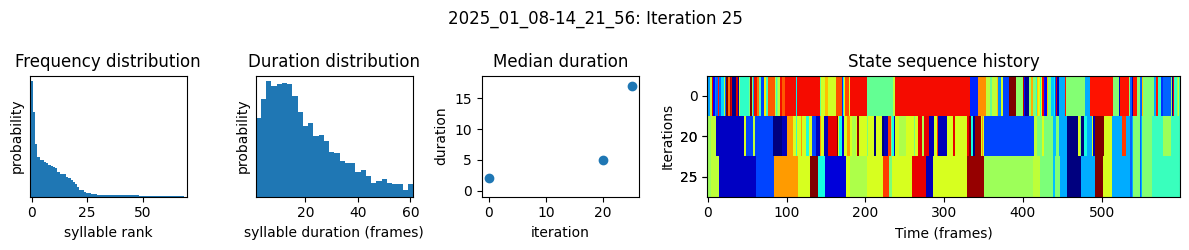

 95%|█████████████████████████████████▎ | 20/21 [03:14<00:08,  8.88s/it]

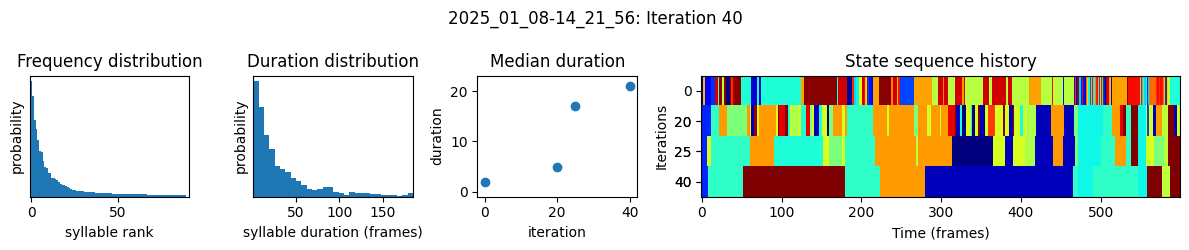

Reindexing: 100%|█████████████| 4/4 [00:00<00:00, 15.31model snapshot/s]


Saved results to /Users/chouda/JaX/KumarLab/unsupervised_behavior_jax/
results/test/2025_01_08-14_21_56/results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Saving trajectory plots to /Users/chouda/JaX/KumarLab/unsupervised_behavior_jax/results/test/2025_01_08-14_21_56/trajectory_plots


Generating trajectory plots: 100%|██████| 10/10 [00:02<00:00,  4.08it/s]


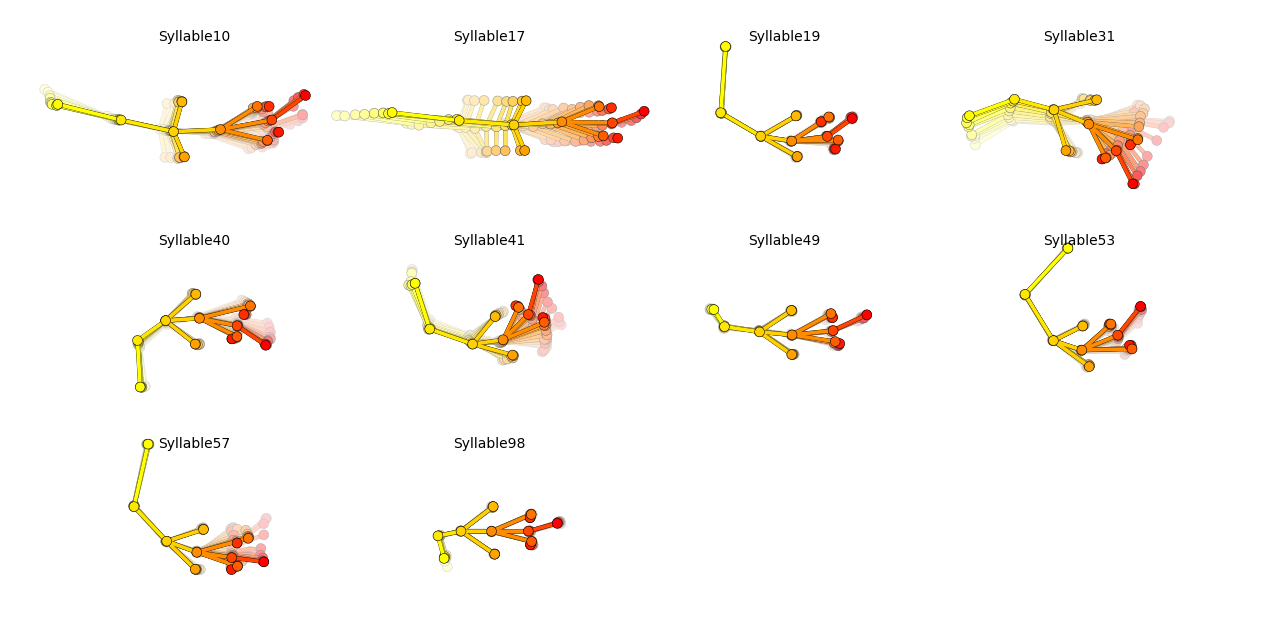

Writing grid movies to /Users/chouda/JaX/KumarLab/unsupervised_behavior_jax/results/test/2025_01_08-14_21_56/grid_movies
Using window size of 128 pixels


Generating grid movies:   0%|                    | 0/18 [00:00<?, ?it/s]/Users/chouda/opt/anaconda3/envs/keypoint_moseq/lib/python3.9/subprocess.py:1770: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Generating grid movies:   6%|▋           | 1/18 [00:05<01:40,  5.94s/it]/Users/chouda/opt/anaconda3/envs/keypoint_moseq/lib/python3.9/subprocess.py:1770: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Generating grid movies:  11%|█▎          | 2/18 [00:07<00:53,  3.32s/it]/Users/chouda/opt/anaconda3/envs/keypoint_moseq/lib/python3.9/subprocess.py:1770: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Generating grid movies:  17%|██          | 3/18 [00:08<00:37,  2.48

Saving dendrogram plot to /Users/chouda/JaX/KumarLab/unsupervised_behavior_jax/results/test/2025_01_08-14_21_56/similarity_dendrogram


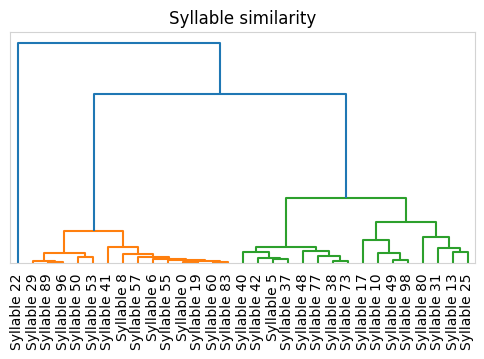

In [16]:
# In case we need to reduce the floating point precision (NOT RECOMMENDED)
# config.update("jax_enable_x64", False) 

if jax.devices()[0].platform != 'cpu':
    logging.info("GPU usage before running the script:")
    print_gpu_usage()

data, metadata, coordinates = load_and_format_data(G_POSE_CSV_DIR, project_path)
config_kpms = lambda: kpms.load_config(project_path)

if jax.devices()[0].platform != 'cpu':
    logging.info("GPU usage after loading data:")
    print_gpu_usage()

pca = perform_pca(data, config_kpms, project_path)

if jax.devices()[0].platform != 'cpu':
    logging.info("GPU usage after performing PCA:")
    print_gpu_usage()
    
model, m_name, m_results = fit_and_save_model(data, metadata, pca, config_kpms, project_path, G_KAPPA, G_ARHMM_ITERS, G_FULL_MODEL_ITERS)

generate_plots_and_movies(m_name, m_results, coordinates, project_path)